<a href="https://colab.research.google.com/github/lintaoye1388/NN-NPC/blob/main/test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantilize training with weights distribution

Loading MNIST (resized to 14x14)...


100%|██████████| 9.91M/9.91M [00:00<00:00, 37.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.13MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.63MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.07MB/s]


Starting Quantized Training (4-bit per cell)...
Differential Pair Effective Levels: ~32
Epoch 1/3 - Loss: 10274.2909
Epoch 2/3 - Loss: 3663.6235
Epoch 3/3 - Loss: 2614.3820
Simulation Complete.


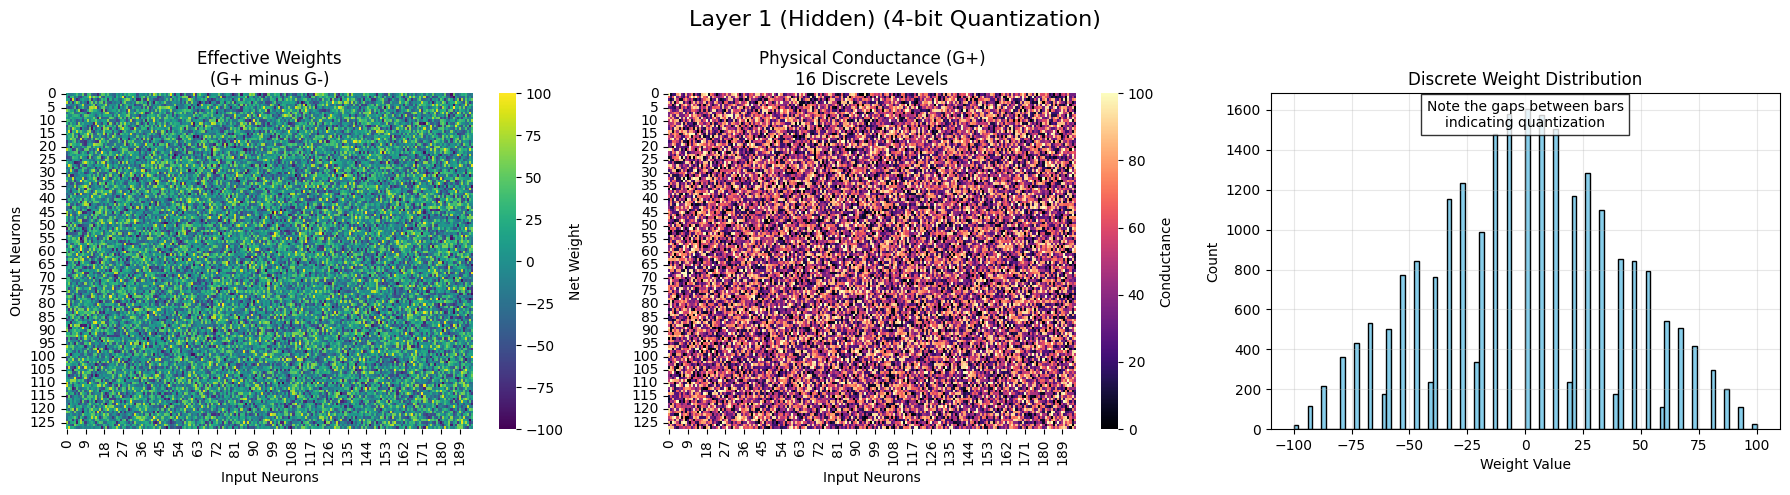

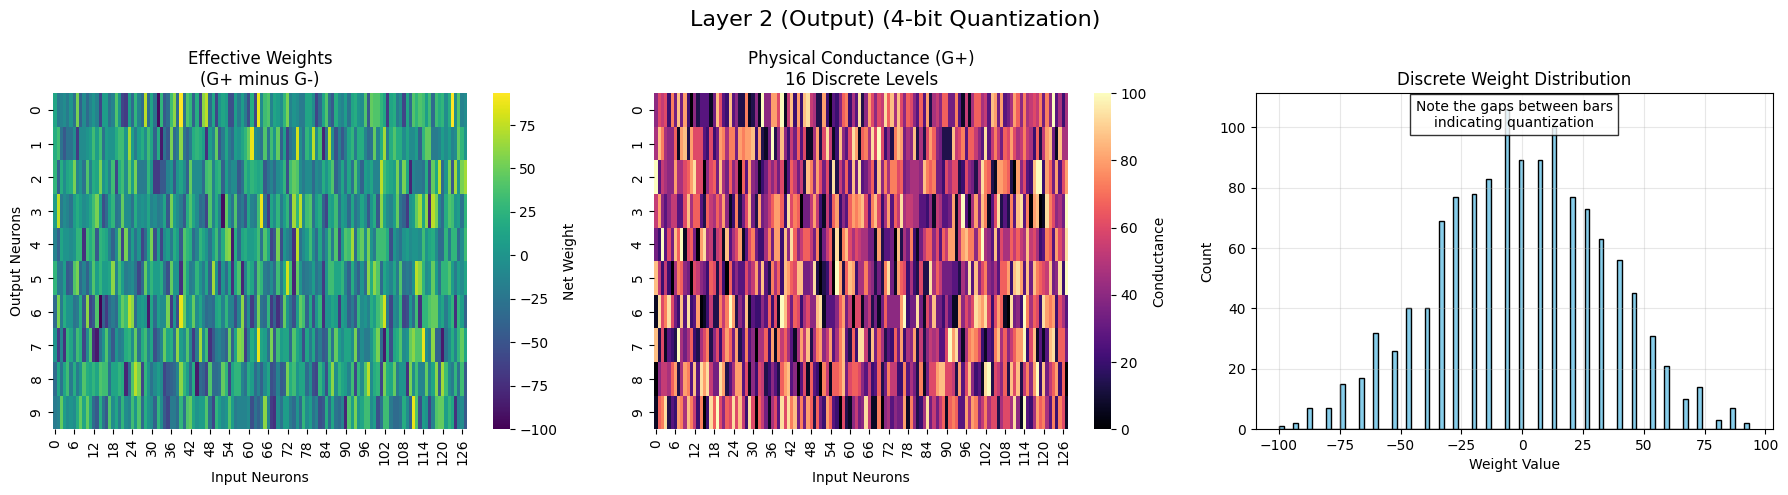

In [ ]:
# @title 4-Bit Memristor Training Simulation { display-mode: "form" }

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# ==========================================
# 1. ADJUSTABLE VARIABLES
# ==========================================

# @markdown ### Hardware / Architecture Settings
INPUT_RESOLUTION = 14 # @param {type:"slider", min:8, max:28, step:1}
HIDDEN_LAYER_SIZE = 128 # @param {type:"integer"}

# @markdown ### Memristor Properties
# We define the conductance range.
G_MIN = 0.0      # Min conductance (simulated 0 for calculation simplicity)
G_MAX = 100.0    # Max conductance (arbitrary units)
BIT_DEPTH = 4    # 4-bit per single memristor cell

# @markdown ### Training Settings
BATCH_SIZE = 64
LEARNING_RATE = 0.01
EPOCHS = 3

# ==========================================
# 2. QUANTIZATION LOGIC (STE)
# ==========================================

class LinearQuantizer(torch.autograd.Function):
    """
    Straight-Through Estimator (STE) for Quantization.
    Forward pass: Quantizes the input to discrete levels.
    Backward pass: Passes the gradient through unchanged (identity).
    """
    @staticmethod
    def forward(ctx, input, g_min, g_max, bit_depth):
        # 1. Calculate number of levels (e.g., 4-bit = 16 levels)
        levels = 2 ** bit_depth - 1

        # 2. Normalize input to [0, 1]
        input_norm = (input - g_min) / (g_max - g_min)

        # 3. Quantize to nearest level
        input_quant = input_norm.mul(levels).round().div(levels)

        # 4. Denormalize back to [g_min, g_max]
        out = input_quant.mul(g_max - g_min) + g_min

        return out

    @staticmethod
    def backward(ctx, grad_output):
        # Straight-Through Estimator:
        # Return gradient as-is for input, None for others
        return grad_output, None, None, None

def quantize(x, g_min, g_max, bit_depth):
    return LinearQuantizer.apply(x, g_min, g_max, bit_depth)

# ==========================================
# 3. MEMRISTOR LAYER
# ==========================================

class MemristorLinear(nn.Module):
    def __init__(self, in_features, out_features, g_min, g_max, bit_depth):
        super(MemristorLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.g_min = g_min
        self.g_max = g_max
        self.bit_depth = bit_depth

        # Initialize latent (high-precision) weights
        # We need high precision for the optimizer to accumulate small changes
        self.g_pos = nn.Parameter(torch.rand(out_features, in_features) * (g_max - g_min) + g_min)
        self.g_neg = nn.Parameter(torch.rand(out_features, in_features) * (g_max - g_min) + g_min)

        self.bias = nn.Parameter(torch.zeros(out_features))

    def forward(self, x):
        # 1. Clamp latent weights to valid physical range first
        with torch.no_grad():
            self.g_pos.clamp_(self.g_min, self.g_max)
            self.g_neg.clamp_(self.g_min, self.g_max)

        # 2. Apply Quantization (simulating the 4-bit cell read)
        #    Note: This uses the STE so gradients can still flow back to g_pos/g_neg
        g_pos_q = quantize(self.g_pos, self.g_min, self.g_max, self.bit_depth)
        g_neg_q = quantize(self.g_neg, self.g_min, self.g_max, self.bit_depth)

        # 3. Differential Pair: W = G+ - G-
        #    If G+ is 4-bit and G- is 4-bit, the result is discrete.
        effective_weight = g_pos_q - g_neg_q

        return nn.functional.linear(x, effective_weight, self.bias)

    def hardware_update_step(self):
        """Helper to keep parameters within bounds after optimizer step"""
        with torch.no_grad():
            self.g_pos.clamp_(self.g_min, self.g_max)
            self.g_neg.clamp_(self.g_min, self.g_max)

class MemristorNet(nn.Module):
    def __init__(self, input_res, hidden_size, g_min, g_max, bit_depth):
        super(MemristorNet, self).__init__()
        input_dim = input_res * input_res
        output_dim = 10

        self.layer1 = MemristorLinear(input_dim, hidden_size, g_min, g_max, bit_depth)
        self.layer2 = MemristorLinear(hidden_size, output_dim, g_min, g_max, bit_depth)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.layer1(x)
        x = self.activation(x)
        x = self.layer2(x)
        return x

    def enforce_constraints(self):
        self.layer1.hardware_update_step()
        self.layer2.hardware_update_step()

# ==========================================
# 4. TRAINING
# ==========================================

print(f"Loading MNIST (resized to {INPUT_RESOLUTION}x{INPUT_RESOLUTION})...")

transform = transforms.Compose([
    transforms.Resize((INPUT_RESOLUTION, INPUT_RESOLUTION)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MemristorNet(INPUT_RESOLUTION, HIDDEN_LAYER_SIZE, G_MIN, G_MAX, BIT_DEPTH).to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

print(f"Starting Quantized Training ({BIT_DEPTH}-bit per cell)...")
print(f"Differential Pair Effective Levels: ~{2**(BIT_DEPTH+1)}")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        model.enforce_constraints()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {running_loss/len(train_loader):.4f}")

print("Simulation Complete.")

# ==========================================
# 5. VISUALIZATION
# ==========================================

def plot_quantized_weights(layer, layer_name):
    # Retrieve the quantized versions for plotting manually
    with torch.no_grad():
        g_pos_q = quantize(layer.g_pos, layer.g_min, layer.g_max, layer.bit_depth)
        g_neg_q = quantize(layer.g_neg, layer.g_min, layer.g_max, layer.bit_depth)
        weights = (g_pos_q - g_neg_q).cpu().numpy()
        g_pos_np = g_pos_q.cpu().numpy()

    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"{layer_name} ({layer.bit_depth}-bit Quantization)", fontsize=16)

    # 1. Effective Weight Heatmap
    sns.heatmap(weights, ax=ax[0], cmap="viridis", cbar_kws={'label': 'Net Weight'})
    ax[0].set_title("Effective Weights\n(G+ minus G-)")
    ax[0].set_xlabel("Input Neurons")
    ax[0].set_ylabel("Output Neurons")

    # 2. Raw Conductance Heatmap
    sns.heatmap(g_pos_np, ax=ax[1], cmap="magma", cbar_kws={'label': 'Conductance'})
    ax[1].set_title(f"Physical Conductance (G+)\n{2**layer.bit_depth} Discrete Levels")
    ax[1].set_xlabel("Input Neurons")

    # 3. Histogram (Crucial for verifying quantization)
    ax[2].hist(weights.flatten(), bins=100, color='skyblue', edgecolor='black')
    ax[2].set_title("Discrete Weight Distribution")
    ax[2].set_xlabel("Weight Value")
    ax[2].set_ylabel("Count")
    ax[2].grid(True, alpha=0.3)

    # Add note about discreteness
    ax[2].text(0.5, 0.9, "Note the gaps between bars\nindicating quantization",
               horizontalalignment='center', transform=ax[2].transAxes,
               bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

plot_quantized_weights(model.layer1, "Layer 1 (Hidden)")
plot_quantized_weights(model.layer2, "Layer 2 (Output)")